<a href="https://colab.research.google.com/github/adibhattar95/Quora-Question-Classification/blob/master/Quora_Classification_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import dataset for training

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from gensim.models import KeyedVectors
import operator
import re
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load and view dataset

In [2]:
df = pd.read_csv('/content/drive/My Drive/train_sample.csv')
df.head()

,qid,question_text,target
0,4.67916E+17,What are some tips for converting seconds sinc...,0
1,5.32726E+17,Why does my most upvoted answer not appear on ...,0
2,6.00031E+17,Which one ia better career option icwai with l...,0
3,6.94202E+17,What macro-molecules would ATP be used in its ...,0
4,1.08073E+18,"What does ""he has a magic range of about 100 m...",0


#View shape of dataset

In [3]:
df.shape

(187105, 3)

In [4]:
#View count of Y (Target column)
df['target'].value_counts()

0    122331
1     64774
Name: target, dtype: int64

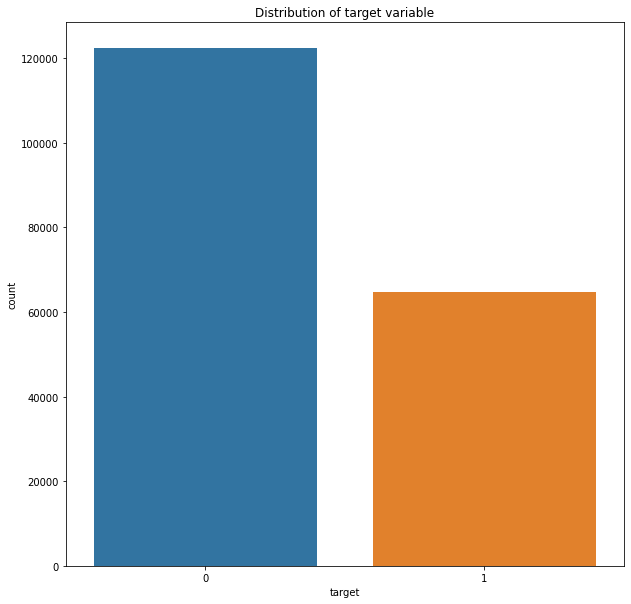

In [5]:
#View countplot of target column
plt.figure(figsize = (10, 10))
sns.countplot(df['target'])
plt.title('Distribution of target variable')
plt.show()

#Extract first word of every question

In [6]:
df['first_word'] = [x .split(' ', 1)[0] for x in df['question_text']]
df.head()

,qid,question_text,target,first_word
0,4.67916E+17,What are some tips for converting seconds sinc...,0,What
1,5.32726E+17,Why does my most upvoted answer not appear on ...,0,Why
2,6.00031E+17,Which one ia better career option icwai with l...,0,Which
3,6.94202E+17,What macro-molecules would ATP be used in its ...,0,What
4,1.08073E+18,"What does ""he has a magic range of about 100 m...",0,What


#View most common question types

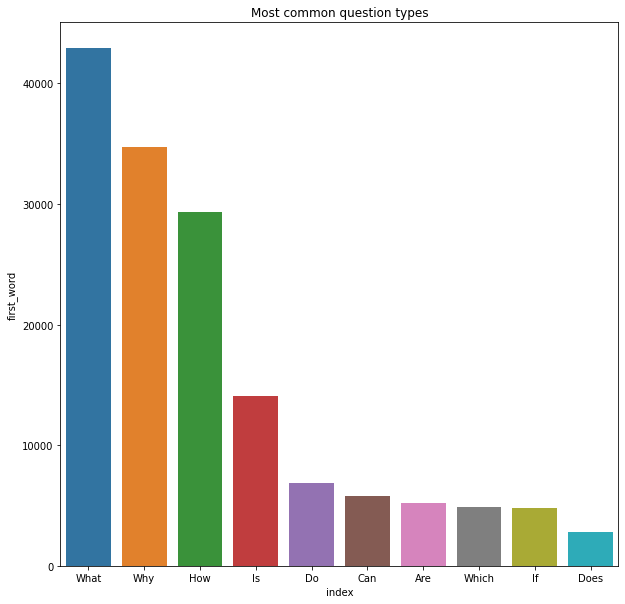

In [7]:
most_common_words = pd.DataFrame(df['first_word'].value_counts()[:10])
most_common_words = most_common_words.reset_index()

plt.figure(figsize = (10, 10))
sns.barplot(x = most_common_words['index'], y = most_common_words['first_word'])
plt.title('Most common question types')
plt.show()

#View average and max question length

In [8]:
df['question_text'] = df['question_text'].astype(str)
df['question_words'] = [q.split(' ') for q in df['question_text']]
df['question_length'] = [len(x) for x in df['question_words']]

print('The maximum question length is {}.'.format(df['question_length'].max()))
print('The average question length is {}.'.format(round(df['question_length'].mean(), 0)))
print('The minimum question length is {}.'.format(df['question_length'].min()))

The maximum question length is 65.
The average question length is 14.0.
The minimum question length is 1.


#Define function to build vocabulary

In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#Build vocab and view first five words

In [10]:
sentences = df["question_text"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 187105/187105 [00:00<00:00, 230961.35it/s]

{'What': 45953, 'are': 34098, 'some': 6689, 'tips': 370, 'for': 27492}


#Use GoogleNews Word embeddings to use in model

In [0]:
news_path = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=True)

#Deine function to compare words in vocab and embeddings and output oov words

In [12]:
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

oov = check_coverage(vocab,embeddings_index)

100%|██████████| 152923/152923 [00:00<00:00, 312027.32it/s]


Found embeddings for 36.25% of vocab
Found embeddings for  78.93% of all text


#Look at top words not in embeddings

In [13]:
oov[:10]

[('to', 64747),
 ('a', 58714),
 ('of', 50369),
 ('and', 44744),
 ('India?', 2230),
 ('it?', 1944),
 ('people?', 1386),
 ('them?', 1332),
 ('do?', 1130),
 ('world?', 1034)]

#Check for certain punctuations in embeddings

In [14]:
print('?' in embeddings_index)
print('&' in embeddings_index)

False
True


#Define function to remove punctuations in vocab which are not in embeddings

In [0]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

#Apply clean_text function on questions

In [16]:
df["question_text"] = df["question_text"].apply(lambda x: clean_text(x))
sentences = df["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 187105/187105 [00:00<00:00, 237030.28it/s]


#Check for match between vocab and embedding after removing punctuation

In [17]:
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 84511/84511 [00:00<00:00, 257230.62it/s]

Found embeddings for 77.22% of vocab
Found embeddings for  90.28% of all text


#Look at top words not in embeddings

In [18]:
oov[:10]

[('to', 65221),
 ('a', 58885),
 ('of', 50668),
 ('and', 45114),
 ('2018', 885),
 ('2017', 839),
 ('10', 816),
 ('12', 535),
 ('15', 461),
 ('11', 412)]

#Numbers greater than 9 are represented by hashes in the embeddings

In [19]:
for i in range(10):
    print(embeddings_index.index2entity[i])

</s>
in
for
that
is
on
##
The
with
said


#Replace numbers greater than 9 in vocab with hashes

In [0]:
def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

#Check for match between vocab and embedding after removing punctuation and numbers

In [21]:
df["question_text"] = df["question_text"].apply(lambda x: clean_numbers(x))
sentences = df["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

oov = check_coverage(vocab,embeddings_index)

100%|██████████| 82362/82362 [00:00<00:00, 288744.45it/s]

Found embeddings for 79.74% of vocab
Found embeddings for  90.91% of all text


#Check top words out of vocab not in embeddings

In [22]:
oov[:20]

[('to', 65221),
 ('a', 58885),
 ('of', 50668),
 ('and', 45114),
 ('Quorans', 242),
 ('doesnt', 214),
 ('didnt', 143),
 ('realise', 138),
 ('isnt', 137),
 ('colour', 129),
 ('favourite', 125),
 ('Brexit', 119),
 ('centre', 106),
 ('bitcoin', 100),
 ('Isnt', 93),
 ('travelling', 86),
 ('behaviour', 86),
 ('Snapchat', 83),
 ('upvotes', 73),
 ('cryptocurrency', 68)]

#Remove common social media terms and replace with 'social medium', remove common stopwords like to, a, of etc

In [23]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium'

                }
mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

df["question_text"] = df["question_text"].apply(lambda x: replace_typical_misspell(x))
sentences = df["question_text"].apply(lambda x: x.split())
to_remove = ['a','to','of','and']
sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)

100%|██████████| 187105/187105 [00:00<00:00, 253881.04it/s]


#Check for match between oov and embeddings_index

In [24]:
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 82331/82331 [00:00<00:00, 276827.92it/s]


Found embeddings for 79.77% of vocab
Found embeddings for  99.08% of all text


#Define X and Y

In [0]:
X = df['question_text'].astype(str)
y = df['target']

#Split data into training and validation

In [0]:
X_train, X_validation, y_train, y_validation = tts(X, y, test_size = 0.2, random_state = 42, stratify = y, shuffle = True)

#Define parameters to use in model

In [0]:
vocab_size = len(vocab)
embedding_dim = 300
trunc_type='post'
oov_tok = "<OOV>"
max_length = len(df['question_words'].max())
max_nb_words = 200000

In [0]:
#Tokenize X_train
tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index

#Convert tweets to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_validation)

#Pad train sequences
X_train = pad_sequences(X_train, max_length, truncating=trunc_type, padding = 'post')
X_validation = pad_sequences(X_validation, max_length, truncating=trunc_type, padding = 'post')

In [29]:
#View shape of X_train and X_test
print(X_train.shape)
print(X_validation.shape)

(149684, 21)
(37421, 21)


In [30]:
#Prepare embedding matrix
print('Preparing embedding matrix')

nb_words = min(max_nb_words, len(word_index))+1

embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in word_index.items():
    if word in embeddings_index.vocab:
        embedding_matrix[i] = embeddings_index.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 21476


In [0]:
#Build Model architecture
model = Sequential([
    Embedding(nb_words, embedding_dim, input_length = max_length, weights = [embedding_matrix], trainable = False),
    tf.keras.layers.Bidirectional(LSTM(128, dropout= 0.2, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(LSTM(64, dropout= 0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
#View model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           18595500  
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 300)           1200      
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 256)           439296    
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [33]:
#Fit model on X_train, y_train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation), verbose=2, batch_size = 32)

Epoch 1/20
4678/4678 - 153s - loss: 0.3183 - accuracy: 0.8743 - val_loss: 0.2836 - val_accuracy: 0.8862
Epoch 2/20
4678/4678 - 152s - loss: 0.2770 - accuracy: 0.8935 - val_loss: 0.2648 - val_accuracy: 0.8958
Epoch 3/20
4678/4678 - 152s - loss: 0.2571 - accuracy: 0.9003 - val_loss: 0.2616 - val_accuracy: 0.8979
Epoch 4/20
4678/4678 - 152s - loss: 0.2445 - accuracy: 0.9057 - val_loss: 0.2566 - val_accuracy: 0.8991
Epoch 5/20
4678/4678 - 152s - loss: 0.2363 - accuracy: 0.9084 - val_loss: 0.2623 - val_accuracy: 0.8948
Epoch 6/20
4678/4678 - 153s - loss: 0.2258 - accuracy: 0.9129 - val_loss: 0.2597 - val_accuracy: 0.8981
Epoch 7/20
4678/4678 - 152s - loss: 0.2213 - accuracy: 0.9143 - val_loss: 0.2660 - val_accuracy: 0.8987
Epoch 8/20
4678/4678 - 153s - loss: 0.2153 - accuracy: 0.9165 - val_loss: 0.2656 - val_accuracy: 0.8961
Epoch 9/20
4678/4678 - 153s - loss: 0.2127 - accuracy: 0.9178 - val_loss: 0.2679 - val_accuracy: 0.8980
Epoch 10/20
4678/4678 - 153s - loss: 0.2069 - accuracy: 0.9208 -

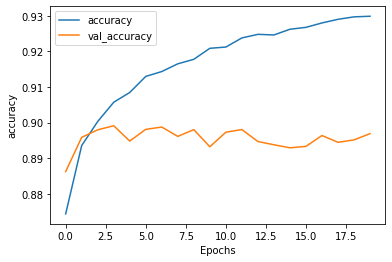

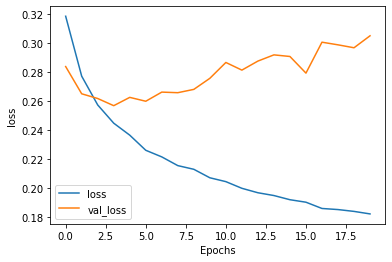

In [34]:
#Define function to plot graph of accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [35]:
#View classification report
y_pred = model.predict_classes(X_validation)

print(classification_report(y_validation, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     24466
           1       0.84      0.86      0.85     12955

    accuracy                           0.90     37421
   macro avg       0.88      0.89      0.89     37421
weighted avg       0.90      0.90      0.90     37421

